#                                             🐱cats VS dogs🐶


## The data set of dogs against cats is a data set that includes the classification of images as containing a dog or cat.

#### The train folder contains 25,000 pictures of dogs and cats.
#### The test folder contains 12,500 images.
#### Each image is a different size, we will set the images to a height of 50 pixels and a width of 50 pixels, a total of  2500 pixels.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
from sklearn.model_selection import cross_val_score # didnt use
from sklearn.model_selection import cross_val_predict  # didnt use
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score  # didnt use
from sklearn.metrics import f1_score  # didnt use
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier
import os
import cv2
import time
from tqdm import tqdm
from random import shuffle
import random

#!pip3 install tqdm

In [2]:
IMG_SIZE = 50

In [3]:
DIR = r'C:\Users\shiratayri\OneDrive\dogs-vs-cats\train'

## Turn the data into a data frame represented by pixels:

We will mark on each picture whether it is a dog or a cat:


In [5]:
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'cat': return 0
    else: return 1

We will translate each image into pixels and add it to the list:

In [6]:
def create_data():
    data = []
    for img in tqdm(os.listdir(DIR)):
        label = label_img(img)
        path = os.path.join(DIR, img)
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
        data.append((np.array(img), label))
    shuffle(data)
    return data

We will create a list to which we will insert the images:

In [7]:
start = time.time()
data = create_data()
end = time.time()
print('runtime:',end - start, 'seconds')

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:25<00:00, 291.49it/s]

runtime: 86.83297491073608 seconds


We will create a data frame from the list:

In [9]:
df = pd.DataFrame(data=np.array([x[0] for x in data]).reshape(25000, IMG_SIZE*IMG_SIZE))
df['label'] = [x[1] for x in data]

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,label
0,255,255,255,255,255,255,255,255,255,255,...,254,254,254,254,255,254,254,254,254,1
1,83,85,94,97,99,102,104,100,104,101,...,68,66,56,83,115,107,104,117,115,1
2,251,251,251,250,249,233,110,199,251,251,...,122,136,125,141,137,148,148,160,197,0
3,254,53,156,249,249,253,245,77,52,169,...,146,150,157,160,159,165,167,177,254,1
4,107,99,104,111,103,111,109,108,111,110,...,143,145,140,160,173,172,170,170,165,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,14,19,16,15,14,15,18,15,15,15,...,63,74,52,49,54,70,62,57,74,1
24996,71,75,78,71,80,77,76,79,82,84,...,42,63,72,95,91,92,52,49,43,0
24997,127,124,124,124,127,130,139,142,151,157,...,248,185,223,240,243,235,231,232,236,0
24998,179,179,179,181,181,181,181,181,181,165,...,85,58,132,138,136,140,88,37,52,0


## Lets split the data


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = df.drop(labels = ['label'], axis=1)
# StandardScaler on the train
a = scaler.fit_transform(x) 
x = pd.DataFrame(a, columns=x.columns)
y = df.label
# We will divide the data frame into training and test and the training will be divided into training and test and we will deal with them
X, X_Test, Y, Y_Test = train_test_split(x, y,random_state=2) 
x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=2) 
print (x_train.shape , x_test.shape)

(14062, 2500) (4688, 2500)


# PCA
###  What is it?
Principal component analysis (PCA) simplifies the complexity in high-dimensional data while retaining trends and patterns. It does this by transforming the data into fewer dimensions, which act as summaries of features.

We will illustrate this with an extreme example:

##### before PCA-

plt.imshow(x_train.to_numpy()[80].reshape(IMG_SIZE,IMG_SIZE) , cmap="gist_yarg")


In [31]:
pca = PCA(n_components=25)
X_reduced = pca.fit_transform(x_train)
X_reduced.shape
#Extreme download for illustration

(14062, 25)

##### after PCA-

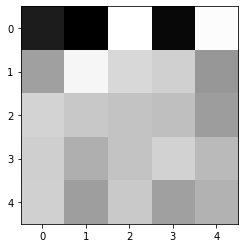

In [33]:
plt.imshow(X_reduced[4].reshape(5,5), cmap=plt.cm.binary)#תמונה לאחר הורדה קיצונית

## Let's run PCA on the data

In [48]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.89) + 1
pca = PCA(n_components=0.89)
X_FTrain = pca.fit_transform(x_train)
X_FTest = pca.transform(x_test)

Number of columns after PCA:

In [50]:
print (X_FTrain.shape , x_test.shape)

(14062, 242) (4688, 2500)


It's less than 10% !

# Models:

Let's start with a bad model called a 'dummy model'. This model is expected to have a poor percentage of accuracy. This model will be a source of comparison for us with the other models. Our goal is to get a much higher accuracy percentage than the accuracy of the dummy.

#### dummy model:

In [56]:
from sklearn.dummy import DummyClassifier
dummy= DummyClassifier(strategy="stratified")
dummy.fit(X_FTrain, y_train)
DummyClassifier(strategy='stratified')
dummy_predict = dummy.predict(X_FTest)
print( "accuracy:" ,dummy.score(y_test, dummy_predict))             #dummy_accuracy

accuracy: 0.5029863481228669


#### knn:

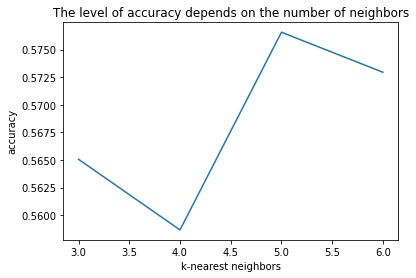

In [62]:
listX=[]
listY=[]
for i in range(3,7):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_FTrain, y_train)
    knn_predict = knn.predict(X_FTest)
    listX.append(i)
    listY.append(accuracy_score(y_test, knn_predict))
    #print(accuracy_score(y_test, knn_predict))
plt.plot(listX, listY)
plt.xlabel("k-nearest neighbors")
plt.ylabel("accuracy")
plt.title("The level of accuracy depends on the number of neighbors")
plt.show()

knn accuracy:

In [60]:
#knn
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_FTrain, y_train)                  # Training of all columns and training of the prediction column
knn_predict = knn.predict(X_FTest)          # predictor (test)
knn_accuracy = accuracy_score(y_test, knn_predict)           # Accuracy tester compared to the test prediction column
knn_accuracy

0.5765784982935154

#### Decision tree:

In [59]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(random_state=1)
dtree.fit(X_FTrain,y_train)                     #training
dtree_predict=dtree.predict(X_FTest)
print( "accuracy:" ,accuracy_score(y_test,dtree.predict(X_FTest)))   #accuracy of testing

accuracy: 0.533703071672355


In [ ]:
def pred(model):
    model.fit(X_FTrain,y_train)
    prediction = model.predict(X_FTest)
    accuracy_score(y_test, prediction)
    print("model: ", model)
    print("Accuracy: ", accuracy_score(y_test, prediction)*100)

#### AdaBoost Classifier:

In [64]:
from sklearn.ensemble import AdaBoostClassifier
pred(AdaBoostClassifier())

model:  AdaBoostClassifier()
Accuracy:  58.21245733788396


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

#### Random forest:

In [ ]:
from sklearn.ensemble import RandomForestClassifier#ניראלי לא אשתמש
arr = []
for i in range(1,21):
    ran = RandomForestClassifier(max_depth=i)
    ran.fit(X_FTrain, y_train)
    ran_predict = ran.predict(X_FTest)
    arr.append(accuracy_score(y_test, ran_predict))

plt.plot(range(1,21), arr)
plt.xticks(np.arange(1,21,1))
plt.xlabel("Max depth value")
plt.ylabel("Score")
plt.show()

ran_accuracy = max(arr)
print ("the maximum Random Forest score is: " + str(ran_accuracy*100) + "% while max depth=12")

#### Pipeline:

In [70]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
pip = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pip.fit(X_FTrain, y_train)
pip_predict = pip.predict(X_FTest)
pip_accuracy = accuracy_score(y_test, pip_predict)*100
print ("Pipeline accuracy: " + str(pip_accuracy) + "%")

Pipeline accuracy: 65.52901023890784%


#### Voting:

In [69]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import tree
clf1 = KNeighborsClassifier(n_neighbors=2)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = GaussianNB()
vot = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
vot.fit(X_FTrain, y_train)
vot_predict = vot.predict(X_FTest)
vot_accuracy = accuracy_score(y_test, vot_predict)*100
print ("Voting accuracy: " + str(vot_accuracy) + "%")

Voting accuracy: 59.02303754266212%


#### Stacking:

In [68]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
estimators = [('rf', RandomForestClassifier(n_estimators=10, random_state=42)), ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))]
sta = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression())
sta.fit(X_FTrain, y_train)
sta_predict = sta.predict(X_FTest)
sta_accuracy = accuracy_score(y_test, sta_predict)*100
print ("Stacking accuracy: " + str(sta_accuracy) + "%")

Stacking accuracy: 55.460750853242324%


### We will illustrate the comparison of accuracy between the models:

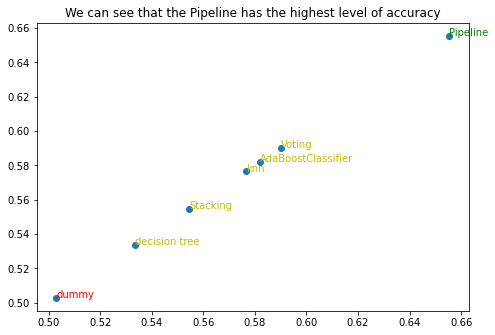

In [99]:
fig= plt.figure()
axes= fig.add_axes([1,1,1,1])
knn= knn_accuracy
decisionTree= accuracy_score(y_test,dtree.predict(X_FTest))
dummy= 0.5029863481228669
AdaBoostClassifier= 0.5821245733788396
Pipeline= 0.6552901023890784
Voting= 0.5902303754266212
Stacking= 0.55460750853242324
x= [knn,decisionTree,dummy,AdaBoostClassifier,Pipeline,Voting,Stacking]
y= [knn,decisionTree,dummy,AdaBoostClassifier,Pipeline,Voting,Stacking]
plt.scatter(x,y)
plt.title("We can see that the Pipeline has the highest level of accuracy")
axes.annotate("knn", xy=(knn,knn) , size=10, color='y')
axes.annotate("decision tree", xy=(decisionTree,decisionTree) , size=10, color='y')
axes.annotate("dummy", xy=(dummy,dummy) , size=10, color='r')
axes.annotate("AdaBoostClassifier", xy=(AdaBoostClassifier,AdaBoostClassifier) , size=10, color='y')
axes.annotate("Pipeline", xy=(Pipeline,Pipeline) , size=10, color='g')
axes.annotate("Voting", xy=(Voting,Voting) , size=10, color='y')
axes.annotate("Stacking", xy=(Stacking,Stacking) , size=10, color='y')

plt.show(x,y)

### We can see that the Pipeline has the highest level of accuracy.

### The highest accuracy is found in the Pipline when the number of columns is less than 10 percent of the number of columns in the complete data. We prefer a compact model in order to improve efficiency.

## Final lecture with the test:

In [ ]:
pip = Pipeline([('scaler', StandardScaler()), ('svc', SVC())])
pip.fit(X_FTrain, y_train)
pip_predict = pip.predict(X_Test)
pip_accuracy = accuracy_score(Y_Test, pip_predict)*100
print ("Pipeline accuracy: " + str(pip_accuracy) + "%")